In [7]:
from duckduckgo_search import DDGS
from itertools import islice
from urllib.request import urlretrieve
from fastai.vision.all import *
from time import sleep  # Add the import statement for the sleep function

def search_images(term, max_images=30):
    """
    Search for images using the DuckDuckGo API.

    Parameters:
        term (str): The search term.
        max_images (int): Maximum number of images to fetch.

    Returns:
        List[str]: List of image URLs.
    """
    print(f"Searching for '{term}'")
    return [img_info['image'] for img_info in islice(DDGS().images(term), max_images)]

def download_image(url, dest):
    """
    Download an image from the given URL and save it to the specified destination.

    Parameters:
        url (str): URL of the image to download.
        dest (str): Path to save the downloaded image.
    """
    urlretrieve(url, dest)




In [6]:
# Create a directory and download images for each search term ('forest' and 'bird')
path = Path('bird_or_not')
searches = ['forest', 'bird']

MAX_IMAGES_PER_TYPE = 30  # Set the maximum number of images to download per type

# Create a directory and download images for each search term ('forest' and 'bird')
for o in searches:
    dest = path / o
    dest.mkdir(exist_ok=True, parents=True)
    for photo_type in ['photo', 'sun photo', 'shade photo']:
        # Download images
        urls = search_images(f'{o} {photo_type}', max_images=100)
        downloaded_images = 0
        for i, url in enumerate(urls):
            if downloaded_images >= MAX_IMAGES_PER_TYPE:
                print(f"Reached the maximum limit of {MAX_IMAGES_PER_TYPE} for {o} {photo_type}.")
                break
            
            dest_file = dest / f'{o}_{photo_type}_{i}.jpg'
            try:
                download_image(url, dest_file)
                downloaded_images += 1
            except Exception as e:
                print(f"Failed to download image {i}: {e}")

            sleep(2)  # Pause between downloads to avoid overloading the server

# Verify and remove any failed images in the downloaded dataset
for i, url in enumerate(urls):
    dest_file = dest / f'{o}_{photo_type}_{i}.jpg'
    try:
        download_image(url, dest_file)
    except Exception as e:
        print(f"Failed to download image {i}: {e}")
    sleep(2) # Pause between downloads to avoid overloading the server



Searching for 'forest photo'
Reached the maximum limit of 30 for forest photo.
Searching for 'forest sun photo'
Failed to download image 5: HTTP Error 403: Forbidden
====Error Body====
<!DOCTYPE html><html lang="en-US"><head><title>Just a moment...</title><meta http-equiv="Content-Type" content="text/html; charset=UTF-8"><meta http-equiv="X-UA-Compatible" content="IE=Edge"><meta name="robots" content="noindex,nofollow"><meta name="viewport" content="width=device-width,initial-scale=1"><link href="/cdn-cgi/styles/challenges.css" rel="stylesheet"></head><body class="no-js"><div class="main-wrapper" role="main"><div class="main-content"><noscript><div id="challenge-error-title"><div class="h2"><span class="icon-wrapper"><div class="heading-icon warning-icon"></div></span><span id="challenge-error-text">Enable JavaScript and cookies to continue</span></div></div></noscript></div></div><script>(function(){window._cf_chl_opt={cvId: '2',cZone: 'wallpapercrafter.com',cType: 'managed',cNounce: 

In [8]:
# Verify and remove any failed images in the downloaded dataset
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
print(f"Number of failed images: {len(failed)}")


Number of failed images: 1


epoch,train_loss,valid_loss,error_rate,time
0,0.983065,1.007110,0.255319,00:29


epoch,train_loss,valid_loss,error_rate,time
0,0.120192,0.270197,0.085106,00:32
1,0.077784,0.168568,0.021277,2:19:21
2,0.050855,0.122650,0.021277,00:35


FileNotFoundError: [Errno 2] No such file or directory: 'bird.jpg'

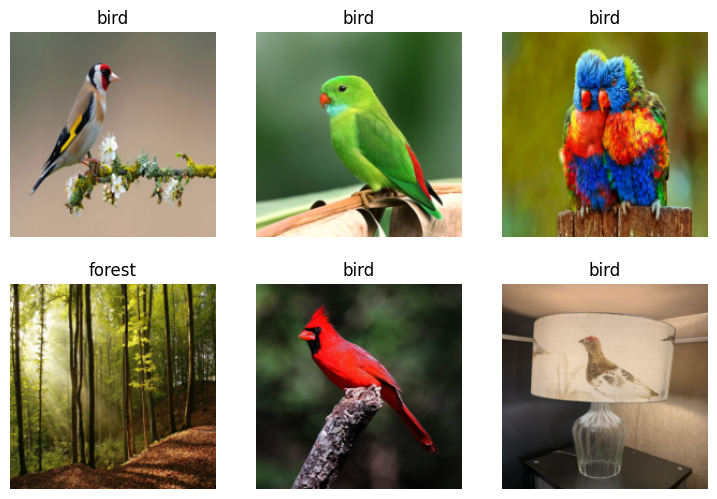

In [9]:

# Create a dataloader for the downloaded images
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

# Show a batch of images from the dataloader
dls.show_batch(max_n=6)

# Create a CNN learner, fine-tune the model, and predict the label of the 'bird.jpg' image
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

# Make a prediction for the 'bird.jpg' image and print the result
is_bird, _ = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")